In [1]:
import sys
import numpy as np
import uproot
import hist
import awkward as ak

import tritonclient.grpc as grpcclient
from tritonclient.utils import InferenceServerException

from coffea import processor
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base

# DEMO: First steps using Triton inference server at coffea-casa facility
__________

To demonstrate the current functionality of inference with Triton at the coffea-casa OD facility, a simple example was developed. Toy "events", each with four randomly generated observables, were created from signal and background classes. The comparison of background and signal distributions can be seen below:
![alt text](images/toydata_truth.png "Histograms of Toy Data Variables")

This data was used to train a simple neural network in PyTorch to classify an event as either signal or background, when given the four input variables. The architecture of this network is shown below. With this simple model architecture, the network achieves around 97\% accuracy.
![alt text](images/binary_classifier.png "Neural Network Architecture")

In order to use this PyTorch model for inference in the Triton server, there are a few steps that need to be taken.

1. The model needs to be a ScriptModule (torch.jit.ScriptModule). This is an analog to torch.nn.Module and is a wrapper around C++. For simple models, such as the one used in this example, this can be done by the command `model = torch.jit.script(model)`.
2. Save the model using `torch.jit.save`
3. Create a directory for your model. For this facility, the directory should be placed in `/mnt`. The structure of the directory must be the following:
```text
        binary_classifier/
        ├── 1
        │   └── model.pt
        └── config.pbtxt
```
    * the subdirectory `1` indicates the model version. You can have multiple versions. `1` contains the model file, which must be named `model.pt`, if using PyTorch.
    * You must also create the config file. The structure of the config file used in this example is printed below. Variable names must be of the form `var__i`, where `i` is an integer. The name of the model in the config file much match the name of the model directory.
    
```
name: "binary_classifier"
platform: "pytorch_libtorch"
max_batch_size: 8
input [
  {
    name: "x"
    data_type: TYPE_FP32
    dims: [ 4 ]
  }
]
output [
  {
    name: "logits"
    data_type: TYPE_FP32
    dims: [ 1  ]
  }
]
```
4. *Current issue:* There should be a nice way to load models into the Triton inference server, but we currently need to restart the server in order to load models.
5. You can check if the model is loaded by running `curl agc-triton-inference-server:8000/v2/models/{model_name}/config`. Let's check if our model is loaded:

In [2]:
!curl -v agc-triton-inference-server:8000/v2/models/binary_classifier/config

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
*   Trying 192.168.41.85:8000...
* Connected to agc-triton-inference-server (192.168.41.85) port 8000 (#0)
> GET /v2/models/binary_classifier/config HTTP/1.1
> Host: agc-triton-inference-server:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 400 Bad Request
< Content-Type: application/json
< Content-Length: 71
< 
* Connection #0 to host agc-triton-inference-server left intact
{"error":"Request for unknown model: 'binary_classifier' is not found"}

In [3]:
# options

# options for triton inference server
verbose     = False # enable verbose output for grpcclient
batch_size  = 1000 # number of events to send in one inference request
url         = "agc-triton-inference-server:8001" # url of inference server. use 8001 for grpcclient and 8000 for httpclient
test_events = "testevents.csv" # input csv file
model_name  = "binary_classifier" # name of ML model to use (make sure it is loaded properly)
model_vers  = "" # specify model version if necessary
num_batches = 5 # number of batches to process (number of events will be num_batches*batch_size)

# options for coffea
num_cores   = 4 # scaling for setup with FuturesExecutor

## Defining coffea processor

In [4]:
processor_base = processor.ProcessorABC

class SigBkgInference(processor_base):
    
    def __init__(self, batch_size, model_name, model_vers, url, verbose):
        
        # histogram to store event variables and inference results
        self.hist = (hist.Hist.new.Reg(50, -7, 7, name="var0", label="Variable 0")
                     .Reg(50, -45, 5, name="var1", label="Variable 1")
                     .Reg(50, 0, 15, name="var2", label="Variable 2")
                     .IntCat(range(2), name="classification", label="ML Classification (Sig/Bkg)")
                     .Weight())
        
        # model information
        self.batch_size = batch_size
        self.model_name = model_name
        self.model_vers = model_vers
        self.url = url
        self.verbose = verbose
        
    def process(self, events):
        
        histogram = self.hist.copy()
        
        # get event variables
        var0 = events.var0
        var1 = events.var1
        var2 = events.var2
        var3 = events.var3
        
        # concatenate event variables (for input into neural network)
        features = ak.concatenate([var0[..., np.newaxis],
                                   var1[..., np.newaxis],
                                   var2[..., np.newaxis],
                                   var3[..., np.newaxis]], axis=1)
        
        
        # create gRPC client (communicates with inference server)
        triton_client = grpcclient.InferenceServerClient(url=self.url, verbose=self.verbose)
        
        # get model info
        model_metadata = triton_client.get_model_metadata(self.model_name, self.model_vers)
        model_config = triton_client.get_model_config(model_name=self.model_name, 
                                                      model_version=self.model_vers)

        model_config = model_config.config
        input_metadata = model_metadata.inputs[0]
        input_config = model_config.input[0]
        output_metadata = model_metadata.outputs[0]
        
        max_batch_size = model_config.max_batch_size
        batch_size = np.minimum(max_batch_size, self.batch_size) # ensure batch_size isn't larger than max_batch_size
        input_name = input_metadata.name
        output_name = output_metadata.name
        dtype = input_metadata.datatype
        
        # get number of batches
        data_length = len(var0)
        num_batches = int(np.ceil(data_length/self.batch_size))
        
        # make inference request for each batch
        classification = []
        startind = 0
        for i in range(num_batches):
            
            # get data for current batch
            if i == num_batches-1: # if we are on last batch
                data_current = features[startind:].to_numpy().astype(np.float32)
            else:
                data_current = features[startind:startind + self.batch_size].to_numpy().astype(np.float32)
            
            startind += self.batch_size
            
            # configure and set inputs
            client = grpcclient
            inpt = [client.InferInput(input_name, data_current.shape, dtype)]
            inpt[0].set_data_from_numpy(data_current)
            
            # configure output
            output = client.InferRequestedOutput(output_name)
            
            # inference request
            results = triton_client.infer(model_name=self.model_name, 
                                          inputs=inpt, 
                                          outputs=[output]).as_numpy(output_name)
            
            # save results
            results = np.round(results).T[0].astype(int)
            classification.extend(results.tolist())
            
                
        triton_client.close() # close client
        
        # fill histogram
        histogram.fill(var0=var0, 
                       var1=var1, 
                       var2=var2, 
                       classification=classification)
            
        output = {"nevents": {events.metadata["dataset"]: len(var0)}, 
                  "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

## Defining schema to load toy data

In [5]:
class ToySchema(BaseSchema):
    
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])
        
    def _build_collections(self, branch_forms):
        names = ["var0", "var1", "var2", "var3"]
        
        output = {}
        for name in names:
            output[name] = branch_forms[name]
        return output

#     @property
#     def behavior(self):
#         behavior = {}
#         behavior.update(base.behavior)
#         return behavior

## Process events

In [6]:
# paths to files
fileset = {'process0': {'files': ['data/testdata0.root',
                                  'data/testdata1.root',
                                  'data/testdata2.root',
                                  'data/testdata3.root',
                                  'data/testdata4.root'],
                        'nevts': 5*20000}
          }

In [7]:
executor = processor.FuturesExecutor(workers=num_cores)

In [8]:
run = processor.Runner(executor=executor, 
                       schema=ToySchema, 
                       savemetrics=True, 
                       metadata_cache={}, 
                       chunksize=500_000)

In [9]:
filemeta = run.preprocess(fileset, treename="events")

Output()

In [10]:
all_histograms, metrics = run(fileset, 
                              "events", 
                              processor_instance=SigBkgInference(batch_size, 
                                                                 model_name, 
                                                                 model_vers, 
                                                                 url, 
                                                                 verbose)
                             )

Output()

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/coffea/processor/executor.py", line 1640, in _work_function
    out = processor_instance.process(events)
  File "/tmp/ipykernel_604/310632309.py", line 42, in process
    model_metadata = triton_client.get_model_metadata(self.model_name, self.model_vers)
  File "/opt/conda/lib/python3.8/site-packages/tritonclient/grpc/__init__.py", line 514, in get_model_metadata
    raise_error_grpc(rpc_error)
  File "/opt/conda/lib/python3.8/site-packages/tritonclient/grpc/__init__.py", line 62, in raise_error_grpc
    raise get_error_grpc(rpc_error) from None
tritonclient.utils.InferenceServerException: [StatusCode.UNAVAILABLE] Request for unknown model: 'binary_classifier' is not found

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/concurrent/futures/process.py", line 239, in _p

Exception: Failed processing file: WorkItem(dataset='process0', filename='data/testdata3.root', treename='events', entrystart=0, entrystop=20000, fileuuid=b'x\xbaf\x0cz\x1e\x11\xed\x8f\xdb\xean~@\xc5~', usermeta={})

In [10]:
import matplotlib.pyplot as plt

In [11]:
all_histograms['hist']

Hist(
  Regular(50, -7, 7, name='var0', label='Variable 0'),
  Regular(50, -45, 5, name='var1', label='Variable 1'),
  Regular(50, 0, 15, name='var2', label='Variable 2'),
  IntCategory([0, 1], name='classification', label='ML Classification (Sig/Bkg)'),
  storage=Weight()) # Sum: WeightedSum(value=99966, variance=99966) (WeightedSum(value=100000, variance=100000) with flow)

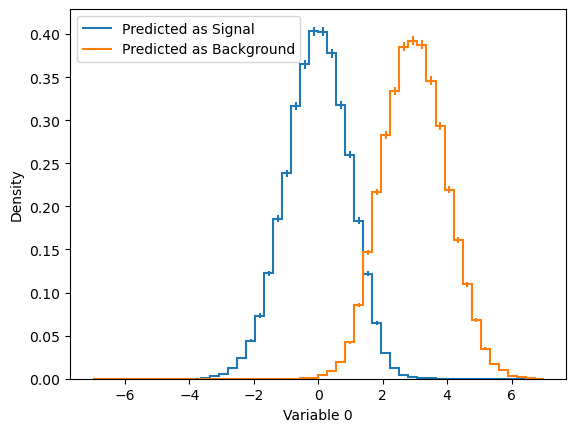

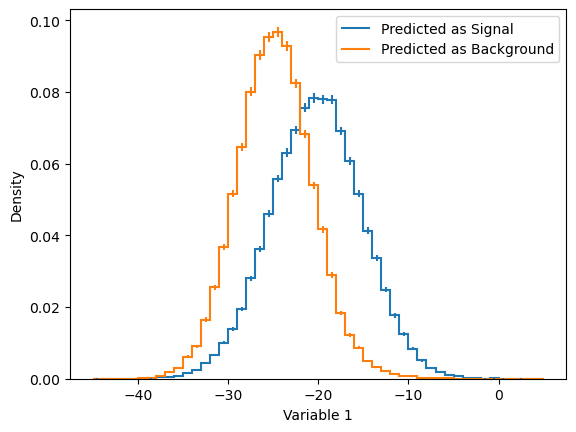

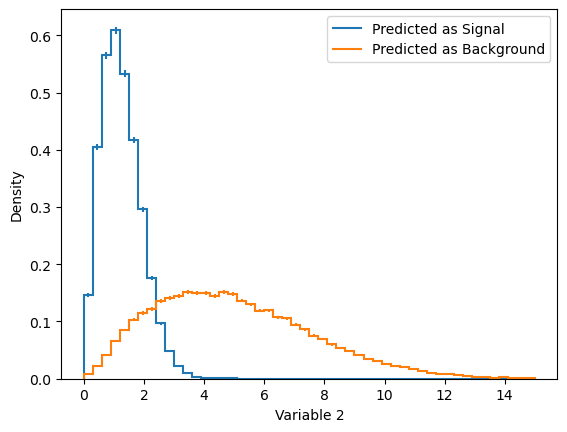

In [12]:
all_histograms['hist'].project("classification", "var0").plot(density=True)
plt.legend(["Predicted as Signal","Predicted as Background"])
plt.ylabel("Density")
plt.show()
all_histograms['hist'].project("classification", "var1").plot(density=True)
plt.legend(["Predicted as Signal","Predicted as Background"])
plt.ylabel("Density")
plt.show()
all_histograms['hist'].project("classification", "var2").plot(density=True)
plt.legend(["Predicted as Signal","Predicted as Background"])
plt.ylabel("Density")
plt.show()